# Automatic Fraud Detection

In [35]:
import pandas as pd 
import numpy as np 
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt

## ETL

In [36]:
df = pd.read_csv("creditcard.csv")
df = df .head(100000)

In [37]:
print(f"There are {df.isnull().sum().sum()} missing values in the dataset.")

There are 0 missing values in the dataset.


In [38]:
fraud_prop = (df["Class"] == 1).sum()/len(df)
print(f"Fraud in the dataset : {fraud_prop}.")
print(f"No fraud in the dataset : {1-fraud_prop}.")

if fraud_prop < 0.4: 
    print("The dataset is imbalanced.")
else: 
    print("The dataset is balanced.")

Fraud in the dataset : 0.00223.
No fraud in the dataset : 0.99777.
The dataset is imbalanced.


<Axes: xlabel='Class', ylabel='count'>

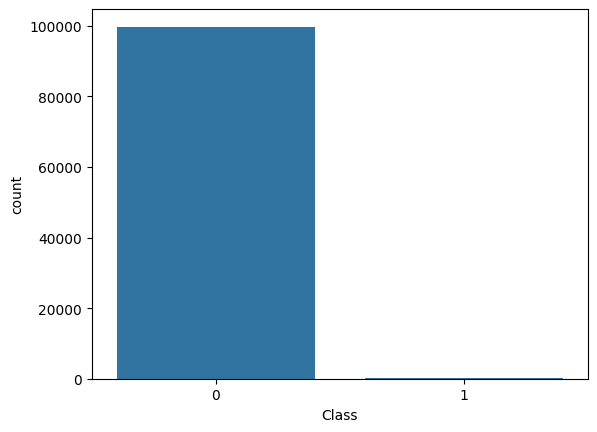

In [39]:
sns.countplot(data=df, x="Class")

Text(0.5, 1.0, 'Distribution of transaction time')

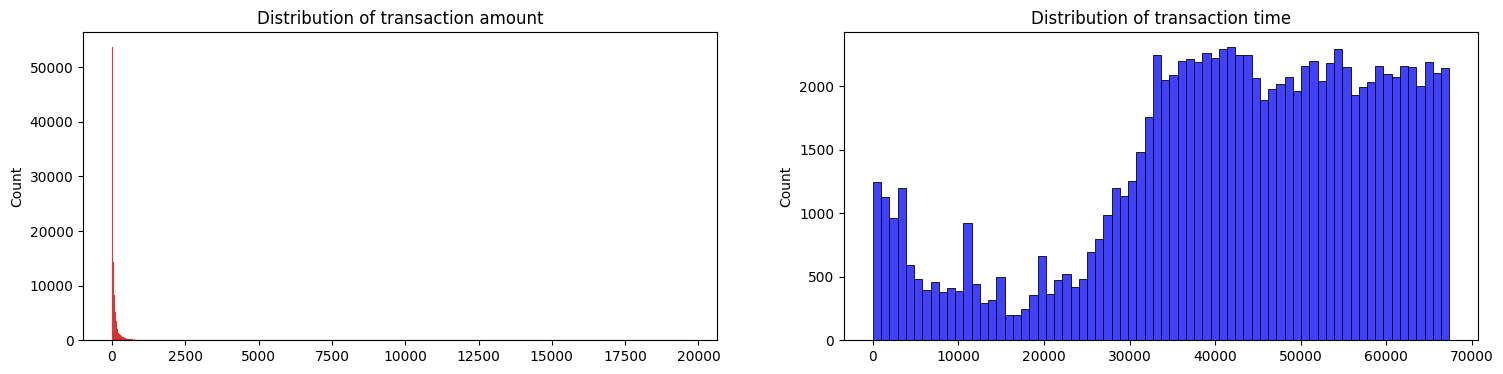

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount = df["Amount"].values
time = df["Time"].values

sns.histplot(amount, ax=ax[0], color='r')
ax[0].set_title("Distribution of transaction amount")

sns.histplot(time, ax=ax[1], color='b')
ax[1].set_title("Distribution of transaction time")

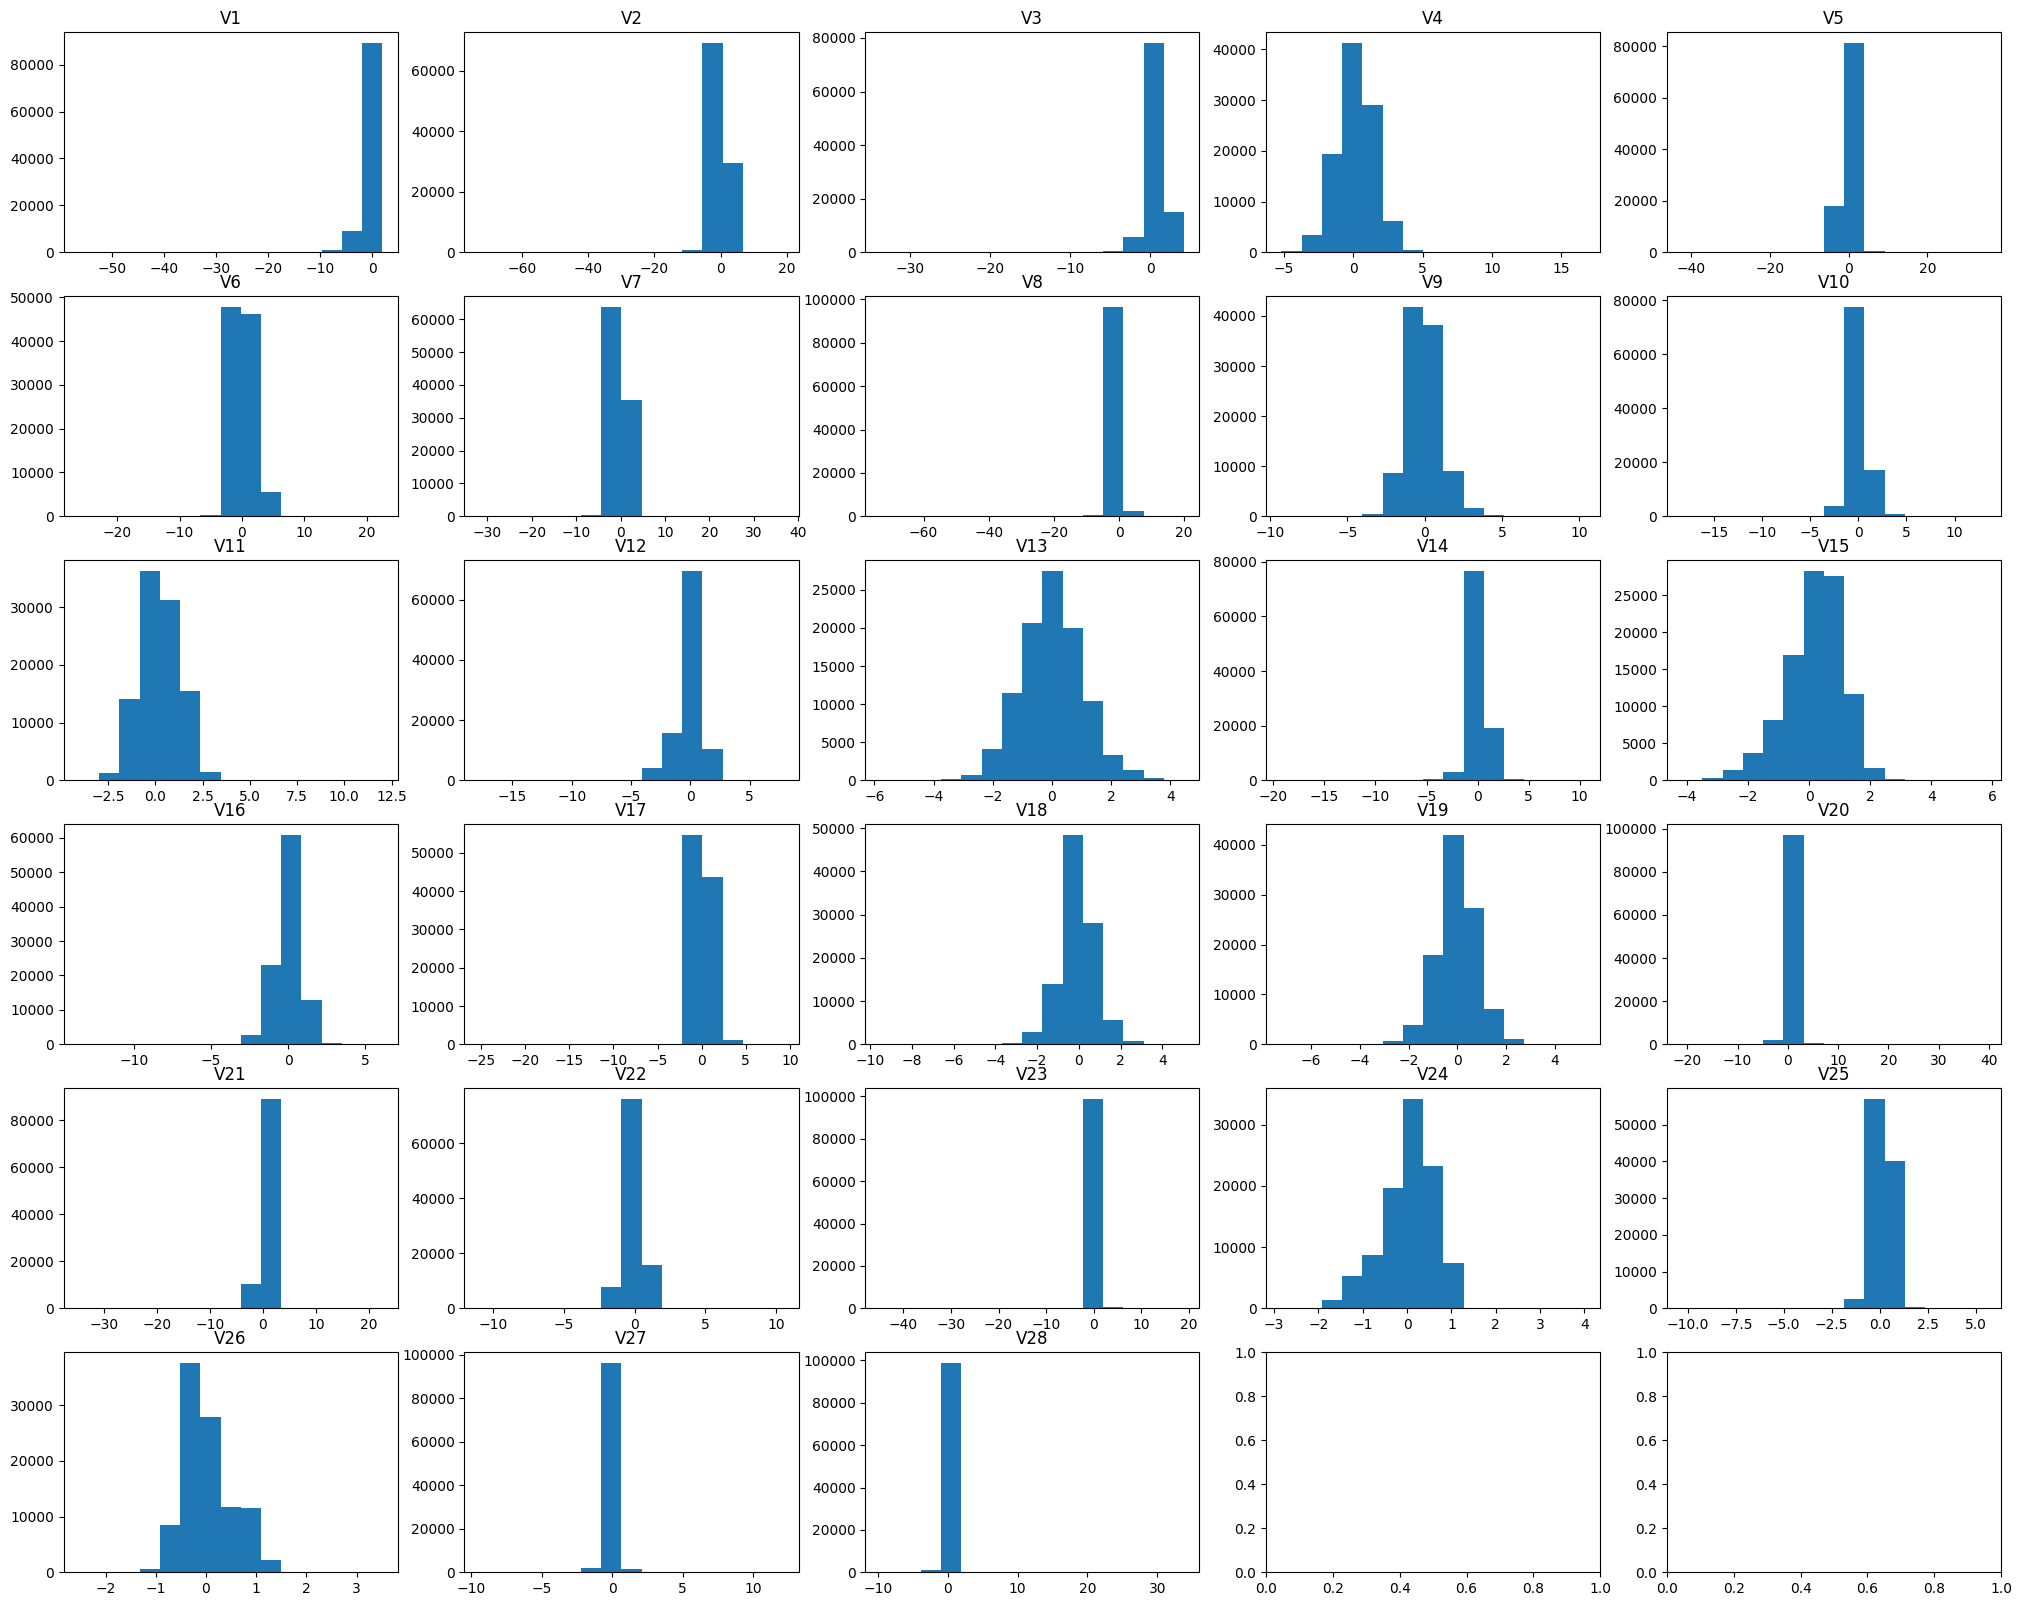

In [41]:
fig, ax = plt.subplots(6,5, figsize=(25, 20))
ax = ax.flatten()

for i in range(28):
    ax[i].hist(df[f"V{i+1}"], bins=15)
    ax[i].set_title(f"V{i+1}")

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df["Amount_scaled"] = scaler.fit_transform(df[["Amount"]])
df["Time_scaled"] = scaler.fit_transform(df[["Time"]])

df = df.drop(["Amount", "Time"], axis=1)

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount_scaled,Time_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.195217,-2.489506
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.360028,-2.489506
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.060755,-2.489448
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.096511,-2.489448
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.105703,-2.489389


## PCA

In [43]:
y = df.pop("Class")
X = df

[0.12340848 0.09981372]


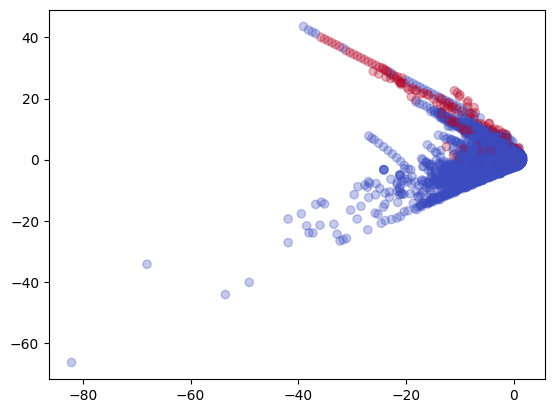

In [52]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', alpha=0.3)

## Modélisation

In [45]:
from sklearn.model_selection import StratifiedKFold



kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[    0     1     2 ... 99997 99998 99999]
  Test:  index=[    3     4    12 ... 99977 99981 99983]
Fold 1:
  Train: index=[    0     1     3 ... 99997 99998 99999]
  Test:  index=[    2     5     9 ... 99982 99986 99995]
Fold 2:
  Train: index=[    2     3     4 ... 99994 99995 99999]
  Test:  index=[    0     1     6 ... 99996 99997 99998]
Fold 3:
  Train: index=[    0     1     2 ... 99996 99997 99998]
  Test:  index=[    7    16    17 ... 99974 99975 99999]
Fold 4:
  Train: index=[    0     1     2 ... 99997 99998 99999]
  Test:  index=[    8    11    23 ... 99991 99993 99994]


In [46]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score, precision_score

df_metrics = pd.DataFrame(columns=["model", "accuracy", "balanced accuracy", "recall", "precision"])

metrics = {
    "accuracy": [],
    "balanced accuracy": [],
    "recall": [],
    "precision": []
}
for i, (train_index, test_index) in enumerate(kfold.split(X,y)):
    print(f"Fold {i}:")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = IsolationForest(random_state=0)
    model.fit(X_train)

    y_pred = model.predict(X_test)
    y_pred = (y_pred == -1)
    #print(y_pred)

    metrics["accuracy"].append(accuracy_score(y_true=y_test, y_pred=y_pred))
    metrics["balanced accuracy"].append(balanced_accuracy_score(y_true=y_test, y_pred=y_pred))
    metrics["recall"].append(recall_score(y_true=y_test, y_pred=y_pred))
    metrics["precision"].append(precision_score(y_true=y_test, y_pred=y_pred))

df_metrics.loc[0] = [
    "IsolationForest",
    np.mean(metrics["accuracy"]),
    np.mean(metrics["balanced accuracy"]),
    np.mean(metrics["recall"]),
    np.mean(metrics["precision"])
]

df_metrics

Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:


,model,accuracy,balanced accuracy,recall,precision
0,IsolationForest,0.95981,0.912889,0.865758,0.046377


In [47]:
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score, precision_score
from xgboost import XGBClassifier

df_metrics = pd.DataFrame(columns=["model", "accuracy", "balanced accuracy", "recall", "precision"])

models = {
    "RandomForestClassifier": RandomForestClassifier(), 
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=0),
    "XGBClassifier": XGBClassifier(n_estimators=100),
    "AdaBoostClassifier": AdaBoostClassifier()
}
i=0
for model_name in models: 
    print(f"Processing {model_name}...")
    metrics = {
    "accuracy": [],
    "balanced accuracy": [],
    "recall": [],
    "precision": []
    }
    for i, (train_index, test_index) in enumerate(kfold.split(X,y)):
        print(f"Fold {i}:")
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = models[model_name]
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)
    
        metrics["accuracy"].append(accuracy_score(y_true=y_test, y_pred=y_pred))
        metrics["balanced accuracy"].append(balanced_accuracy_score(y_true=y_test, y_pred=y_pred))
        metrics["recall"].append(recall_score(y_true=y_test, y_pred=y_pred))
        metrics["precision"].append(precision_score(y_true=y_test, y_pred=y_pred))
    
    df_metrics.loc[i] = [
        model_name,
        np.mean(metrics["accuracy"]),
        np.mean(metrics["balanced accuracy"]),
        np.mean(metrics["recall"]),
        np.mean(metrics["precision"])
    ]
    i+=1

df_metrics

Processing RandomForestClassifier...
Fold 0:
Fold 1:


KeyboardInterrupt: 

## SMOTE 